In [1]:
import torch
import torch.nn as nn
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast, DistilBertModel
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler
import time, datetime, random, re
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from optuna.pruners import SuccessiveHalvingPruner
from optuna.samplers import TPESampler
from torch.cuda.amp import autocast, GradScaler
from torch.optim import AdamW
from tqdm.notebook import tqdm

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from transformers import pipeline
from operator import itemgetter
from tqdm.notebook import tqdm

import json
import pandas as pd
import numpy as np
from scipy.stats import mode
from sklearn.model_selection import train_test_split
import pickle

SEED = 15
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.cuda.amp.autocast(enabled=True)
device = torch.device("cuda")

2023-05-15 05:26:28.432559: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-15 05:26:29.086157: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Tokens prep

In [11]:
with open('./data/papers_merged.pickle', 'rb') as f:
    fetched_data = pickle.load(f)

physics = {'quant-ph', 'physics', 'nucl-th', 'nucl-ex', 'nlin', 
           'math-ph', 'hep-th', 'hep-ph', 'hep-lat', 'hep-ex', 
           'gr-qc', 'cond-mat', 'astro-ph', 'adap-org', 'physics'}

tags_names = {
    'cs': 'Computer Science',
    'econ': 'Economics',
    'eess': 'Electrical Engineering and Systems Science',
    'math': 'Mathematics',
    'physics': 'Physics',
    'q-bio': 'Quantitative Biology',
    'q-fin': 'Quantitative Finance',
    'stat': 'Statistics',
}

def get_cat(tag):
    # returns tag category as number / -1 if unkown
    tag = tag.split('.')[0]
    if tag in physics:
        return "physics"
    return tag

def remove_mul_spaces(text):
    return re.sub(r"\s+", " ", text)

data = pd.DataFrame([{'title': remove_mul_spaces(paper['title']),
                      'summary': remove_mul_spaces(paper['summary']),
                      'category': get_cat(paper['arxiv_primary_category']['term'])} for paper in fetched_data])

cat = pd.Categorical(data.category)
data = data\
    .drop(columns=['category'])\
    .assign(category=cat.codes)

In [13]:
for dat in fetched_data:
    if get_cat(dat['arxiv_primary_category']['term']) == 'physics':
        print(dat)
        break

{'id': 'http://arxiv.org/abs/2305.04435v1', 'guidislink': True, 'link': 'http://arxiv.org/abs/2305.04435v1', 'updated': '2023-05-08T03:10:08Z', 'updated_parsed': time.struct_time(tm_year=2023, tm_mon=5, tm_mday=8, tm_hour=3, tm_min=10, tm_sec=8, tm_wday=0, tm_yday=128, tm_isdst=0), 'published': '2023-05-08T03:10:08Z', 'published_parsed': time.struct_time(tm_year=2023, tm_mon=5, tm_mday=8, tm_hour=3, tm_min=10, tm_sec=8, tm_wday=0, tm_yday=128, tm_isdst=0), 'title': 'Communication complexity of entanglement assisted multi-party\n  computation', 'title_detail': {'type': 'text/plain', 'language': None, 'base': '', 'value': 'Communication complexity of entanglement assisted multi-party\n  computation'}, 'summary': "We consider a quantum and classical version multi-party function computation\nproblem with $n$ players, where players $2, \\dots, n$ need to communicate\nappropriate information to player 1, so that a ``generalized'' inner product\nfunction with an appropriate promise can be cal

In [3]:
 cat.categories

Index(['cs', 'econ', 'eess', 'math', 'physics', 'q-bio', 'q-fin', 'stat'], dtype='object')

In [4]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english')

goal_num = 7_000
num_samples = {cat : min(num, goal_num) for cat, num in data.category.value_counts().reset_index().values}
data_undersamp, _ = RandomUnderSampler(sampling_strategy=num_samples)\
    .fit_resample(data, data.category)
train_data, val_data = train_test_split(data_undersamp, test_size=.1, stratify=data_undersamp.category)

shuffled = np.arange(len(train_data))
np.random.shuffle(shuffled)
train_data = train_data.iloc[shuffled]

MAX_LENGTH_TITLE = 30
MAX_LENGTH_SUMM = 290

def batch_encode(tokenizer, df, return_tensors='pt', batch_size=256):
    # return list of batches (input_ids, attention_mask) and list of batches of y
    title, summ = df.title.to_list(), df.summary.to_list()
    y = df.category.values
    
    encoded = []
    ys = []
    getter = itemgetter('input_ids', 'attention_mask')
    
    for i in tqdm(range(0, len(title), batch_size)):
        slice_ = slice(i, i + batch_size)
        batch_t = title[slice_]
        batch_s = summ[slice_]
        
        inputs = []
        for batch, max_length  in [(batch_t, MAX_LENGTH_TITLE), (batch_s, MAX_LENGTH_SUMM)]:
            inputs.extend(getter(tokenizer.batch_encode_plus(
                batch,
                max_length=max_length,
                padding='longest',
                truncation=True,
                return_attention_mask=True,
                return_token_type_ids=False,
                return_tensors=return_tensors
            )))
        
        encoded.append(inputs)
        ys.append(torch.tensor(y[slice_]).to(int))
    
    return encoded, ys

In [5]:
train_seq, val_seq = (batch_encode(tokenizer, df, batch_size=32) for df in [train_data, val_data])

  0%|          | 0/1407 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

In [6]:
# import pickle

# with open('./data/encoded.pickle', 'wb+') as f:
#     pickle.dump({'train': train_seq, 'val': val_seq}, f)

In [7]:
# with open('./data/encoded.pickle', 'rb') as f:
#     pickle_obj = pickle.load(f)
# train_seq, val_seq = pickle_obj['train'], pickle_obj['val']

In [8]:
from torch.utils.data import Dataset, DataLoader
import numpy as np
from random import shuffle

class MyDataset(Dataset):
    def __init__(self, seq, epoch_size=None):
        super().__init__()
        self.X, self.y = seq
        self.epoch_size = epoch_size or len(self.X)

    def __len__(self):
        return self.epoch_size

    def __getitem__(self, idx):
        if idx >= self.epoch_size:
            raise IndexError
        return self.X[idx], self.y[idx]
    
    def reshuffle(self):
        zipped = list(zip(self.X, self.y))
        shuffle(zipped)
        self.X, self.y = zip(*zipped)

def get_prediction(logits_on_gpu):
    return logits_on_gpu.argmax(axis=1).flatten().detach().cpu().numpy()

def get_topp(logits_on_gpu, p):
    proba, inds = logits_on_gpu.softmax(dim=-1).detach().cpu().to(float).topk(2)
    return list(zip(inds, proba))
    # vals, inds = logits_on_gpu.softmax(dim=-1).detach().cpu().to(float).sort()
    # ret = []
    # for val, ind in zip(vals, inds):
    #     mask = ~(val.cumsum(dim=-1) < (1 - p))
    #     ret.append([ind[mask].flip(dims=[-1])[:3], val[mask].flip(dims=[-1])[:3]])
    # return ret

def topp_accuracy(topp, y_true_cpu):
    return sum([label_true in labels_pred 
                for (labels_pred, _), label_true in zip(topp, y_true_cpu)])\
            / len(y_true_cpu)

def train(model, dataloader, optimizer, scaler, loss_fn, scheduler, exp_mean_alpha = .8):
    # the greater exp_mean_alpha, the lesser influence of new means
    train_total_loss = 0
    total_train_f1 = 0

    model.train()
    
    dataloader.reshuffle()
    pbar = tqdm(dataloader)
    cur_acc = None
    cur_topp = None
    for X, y_true in pbar:
        X = [x.to(device) for x in X]
        y_true_cpu = y_true
        y_true = y_true.to(device)
        
        optimizer.zero_grad()
        with autocast():
            logits = model(*X)
        loss = loss_fn(logits, y_true)
        train_total_loss += loss.item()
            

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        y_pred = get_prediction(logits)
        total_train_f1 += f1_score(y_pred, y_true_cpu,
                                   average='weighted',
                                   labels=np.arange(len(cat.categories)))
        
        topp_score = topp_accuracy(get_topp(logits, .95), y_true_cpu)
        acc_score = accuracy_score(y_pred, y_true_cpu)
        if cur_acc is None:
            cur_acc = acc_score
            cur_topp = topp_score
        else:
            cur_acc = cur_acc * exp_mean_alpha + acc_score * (1 - exp_mean_alpha)
            cur_topp = cur_topp * exp_mean_alpha + topp_score * (1 - exp_mean_alpha)
            
        pbar.set_description(f"Accuracy: {cur_acc:.4f}, top95: {cur_topp: .4f}")
        

    avg_train_loss = train_total_loss / len(dataloader)
    avg_train_f1 = total_train_f1 / len(dataloader)
    
    torch.cuda.empty_cache()
    
    return {
        'loss': avg_train_loss,
        'f1': avg_train_f1,
        'accuracy': cur_acc,
        'top95_acc': cur_topp
    }

def validate(model, dataloader, loss_fn, **kwargs):
    model.eval()

    metrics = {"f1": 0, "precision": 0, "recall": 0, "loss": 0, "accuracy": 0, "top95_acc": 0}
    
    for X, y_true in tqdm(dataloader):
        X = [x.to(device) for x in X]
        y_true_cpu = y_true
        y_true = y_true.to(device)
                                        
                                        
        with torch.no_grad():
            logits = model(*X)
        loss = loss_fn(logits, y_true)

        metrics["loss"] += loss.item()
        y_pred = get_prediction(logits)
        
        for func, metric in ((f1_score, "f1"), (precision_score, "precision"), (recall_score, "recall")):
            metrics[metric] += func(y_pred, y_true_cpu, average="weighted", labels=np.arange(len(cat.categories)))
        metrics["accuracy"] += accuracy_score(y_pred, y_true_cpu)
        metrics["top95_acc"] += topp_accuracy(get_topp(logits, .95), y_true_cpu)

    for metric in metrics:
        metrics[metric] /= len(dataloader)

    torch.cuda.empty_cache()
    return metrics

In [10]:
from pathlib import Path

class MyModel(nn.Module):
    def __init__(self, path=None, n_labels=8):
        super().__init__()
        self.transformer = None
        if path is None:
            self.transformer = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.classifier = nn.Sequential(
            nn.Linear(in_features=768*2, out_features=1024),
            nn.ReLU(),
            torch.nn.BatchNorm1d(num_features=1024),
            nn.Dropout(.2),
            nn.Linear(in_features=1024, out_features=1024),
            nn.ReLU(),
            torch.nn.BatchNorm1d(num_features=1024),
            nn.Dropout(.2),
            nn.Linear(in_features=1024, out_features=n_labels)
        )
        
        if path is not None:
            self.load(path)
    
    def forward(self, input_ids_title, attention_mask_title, input_ids_sum, attention_mask_sum):
        X_title = self.transformer(input_ids=input_ids_title, attention_mask=attention_mask_title)[0][:, 0]
        X_sum = self.transformer(input_ids=input_ids_sum, attention_mask=attention_mask_sum)[0][:, 0]
        X = torch.concat((X_title, X_sum), dim=-1)
        y = self.classifier(X)
        return y
    
    def save(self, path):
        path = Path(path)
        if not path.exists():
            path.mkdir()
        torch.save(self.classifier.state_dict(), path / "clf.pt")
        self.transformer.save_pretrained(path / "transformer-chkp")
        
    def load(self, path):
        path = Path(path)
        self.transformer = DistilBertModel.from_pretrained(
            path / "transformer-chkp",
            local_files_only=True
        )
        self.classifier.load_state_dict(torch.load(path / "clf.pt"))

In [10]:
import warnings
warnings.filterwarnings('ignore')

from IPython.display import clear_output

def plot(acc_history, metrics, path=None):
    if len(acc_history['train']) > 1:
        f, axes = plt.subplots(1, len(metrics))
        f.set_size_inches(15, 5)
        
        for ax, metric in zip(axes, metrics):
            acc_history = {stage : pd.DataFrame(df) for stage, df in acc_history.items()}
            df = pd.concat(pd.DataFrame({'value': df[metric], 'epoch': list(df.index + 1), 'stage': stage})
                           for stage, df in acc_history.items())
            sns.lineplot(data=df, x='epoch', y='value', hue='stage', ax=ax)
            ax.set_xlabel('epoch')
            ax.set_title(metric)
            
        if path is not None:
            plt.savefig(path)
        plt.show()
    else:
        print(acc_history)
        

In [ ]:
from pathlib import Path
tokenizer = DistilBertTokenizerFast.from_pretrained(
    Path("./models/05") / "tokenizer-chkp",
    local_files_only=True
)

In [9]:
MyModel("./models/05")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


TypeError: empty() received an invalid combination of arguments - got (tuple, dtype=NoneType, device=NoneType), but expected one of:
 * (tuple of ints size, *, tuple of names names, torch.memory_format memory_format, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
 * (tuple of ints size, *, torch.memory_format memory_format, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)


In [2]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english')

In [3]:
tokenizer.save_pretrained("models/05/tokenizer-chkp")

('models/05/tokenizer-chkp/tokenizer_config.json',
 'models/05/tokenizer-chkp/special_tokens_map.json',
 'models/05/tokenizer-chkp/vocab.txt',
 'models/05/tokenizer-chkp/added_tokens.json',
 'models/05/tokenizer-chkp/tokenizer.json')

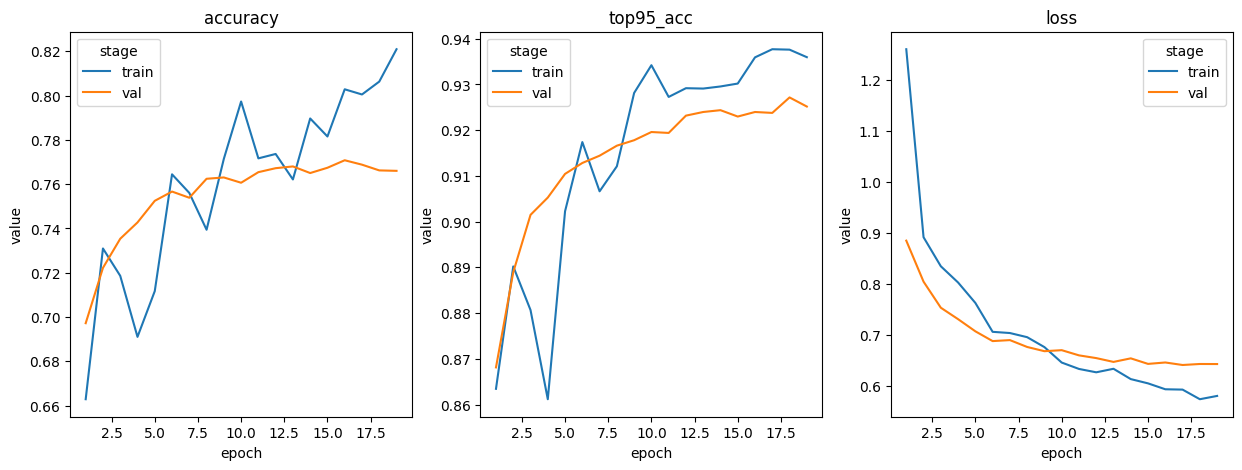

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

In [11]:
samples_per_epoch = 400
epochs = 20
train_set = MyDataset(train_seq, samples_per_epoch)
val_set = MyDataset(val_seq)
model = MyModel()
loss_fn = torch.nn.CrossEntropyLoss()
model.cuda()

optimizer = AdamW(model.parameters(),
                  lr=6.3e-6,
                  weight_decay=0.65
                )

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=len(train_set) * epochs)

acc_history = {'train': [], 'val': []}
params = dict(
    optimizer=optimizer,
    scaler=GradScaler(),
    scheduler=scheduler,
    loss_fn=loss_fn,
    exp_mean_alpha=0.95
)

for _ in range(epochs):
    clear_output(True)
    plot(acc_history, ["accuracy", "top95_acc", "loss"], f"plots/model_5.png")

    acc_history['train'].append(train(model, train_set, **params))
    acc_history['val'].append(validate(model, val_set, **params))
model.save(f'models/05')

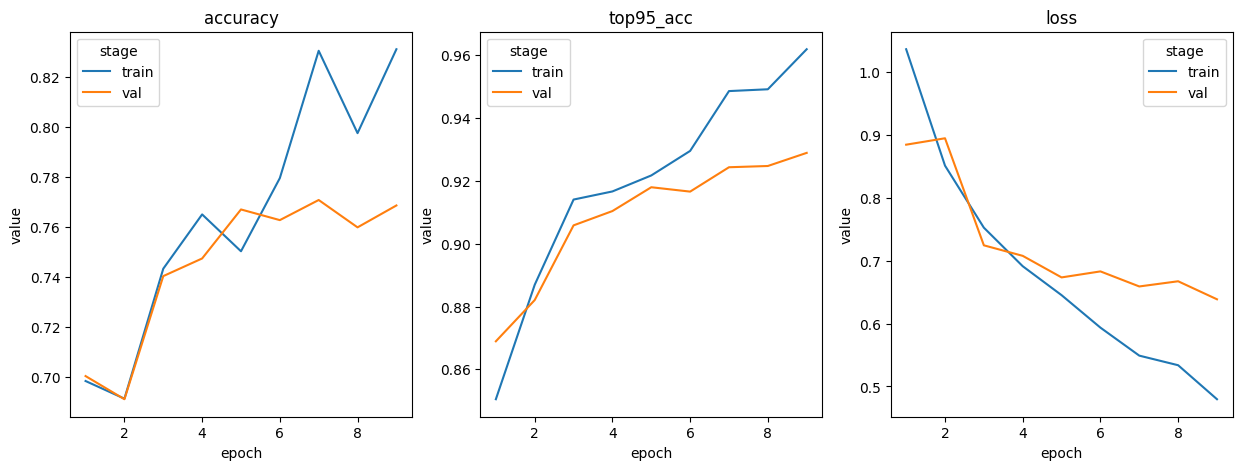

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

In [22]:
samples_per_epoch = 200
epochs = 10
train_set = MyDataset(train_seq, samples_per_epoch)
val_set = MyDataset(val_seq)

history = {}
for i, lr in enumerate(np.logspace(-7, -4, 6)):
    if i == 0:
        continue
    loss_fn = torch.nn.CrossEntropyLoss()
    model.load("models/04_base")
    model.cuda()

    optimizer = AdamW(model.parameters(),
                      lr=lr,
                      weight_decay=0.65
                    )

    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0,
                                                num_training_steps=len(train_set) * epochs)
    
    acc_history = {'train': [], 'val': []}
    params = dict(
        optimizer=optimizer,
        scaler=GradScaler(),
        scheduler=scheduler,
        loss_fn=loss_fn,
        exp_mean_alpha=0.95
    )

    for _ in range(epochs):
        clear_output(True)
        plot(acc_history, ["accuracy", "top95_acc", "loss"], f"plots/{i}.png")
        
        acc_history['train'].append(train(model, train_set, **params))
        acc_history['val'].append(validate(model, val_set, **params))
    history[lr] = acc_history
    model.save(f'models/04_{i}')

In [7]:
tokenizer.encode_plus(
    "fjdkls isijf s",
    max_length=30,
    return_tensors='pt'
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


{'input_ids': tensor([[  101,  1042,  3501,  2094,  2243,  4877,  2003, 28418,  2546,  1055,
           102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [12]:
np.logspace(-7, -4, 6)[3]

6.30957344480193e-06

In [ ]:
tokenizer.encode_plus("I'm here")

{'input_ids': [101, 1045, 1005, 1049, 2182, 102], 'attention_mask': [1, 1, 1, 1, 1, 1]}

In [ ]:
tokenizer.get_vocab()

{'hampshire': 7035,
 'stroked': 11699,
 'persuasion': 27577,
 '##foil': 24323,
 'cartridge': 15110,
 'stumble': 21811,
 'dean': 4670,
 '##ize': 4697,
 'hindwings': 15998,
 '##65': 26187,
 'calming': 23674,
 '##cz': 27966,
 'maris': 23787,
 '##rangle': 21476,
 '##し': 30183,
 'doe': 18629,
 'chocolate': 7967,
 '##graph': 14413,
 'interceptions': 18387,
 'longevity': 26906,
 'kingsley': 22819,
 'cover': 3104,
 'nara': 27544,
 'reducing': 8161,
 '⟩': 1630,
 '##tung': 21847,
 'knocking': 10591,
 'clear': 3154,
 'announcer': 14073,
 '##mis': 15630,
 'romania': 6339,
 '##pc': 15042,
 'attach': 22476,
 'authoritarian': 27246,
 '##>': 29631,
 'affection': 12242,
 'favourites': 28271,
 'garden': 3871,
 'outstanding': 5151,
 '##一': 30266,
 'rudolf': 12794,
 'learners': 26262,
 '##tees': 28313,
 'computational': 15078,
 '##ruck': 29314,
 'coupe': 15130,
 '疒': 1913,
 'physician': 7522,
 'occur': 5258,
 'barr': 19820,
 'unwanted': 18162,
 'ric': 26220,
 '46th': 27990,
 'soaking': 22721,
 'erupted': 

In [ ]:
toks = tokenizer("Hi, I'm steve", max_length=MAX_LENGTH_SUMM, truncation=True, return_attention_mask=True,
    return_token_type_ids=False, return_tensors='np')

In [ ]:
feed = dict(
    input_ids=np.array(toks["input_ids"]).astype("int64"),
  attention_mask=np.array(toks["attention_mask"]).astype("int64"),
)

('./models/02_local-pt-checkpoint/tokenizer_config.json',
 './models/02_local-pt-checkpoint/special_tokens_map.json',
 './models/02_local-pt-checkpoint/vocab.txt',
 './models/02_local-pt-checkpoint/added_tokens.json',
 './models/02_local-pt-checkpoint/tokenizer.json')